In [177]:
import pandas as pd
import numpy as np
import os 
import warnings
from sklearn.preprocessing import minmax_scale
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

warnings.filterwarnings('ignore')

In [178]:
wd_path = ""
id = ['BTC']

In [179]:
for i in id:
    for filename in os.listdir(wd_path+'/{}'.format(i)):
        if filename.endswith('.part'): 
            old_filepath = os.path.join(wd_path+'/{}'.format(i), filename) 
            new_filename = filename.replace('.part', '.csv')  
            new_filepath = os.path.join(wd_path+'/{}'.format(i), new_filename)  

            os.rename(old_filepath, new_filepath)  

print("파일 이름 변경이 완료되었습니다.")

파일 이름 변경이 완료되었습니다.


In [180]:
df_dict = {}

for i in id:
    csv_files = [f for f in os.listdir(os.path.join(wd_path, str(i))) if f.endswith('.csv')]

    df_list = []

    for csv_file in csv_files:
        df = pd.read_csv(os.path.join(wd_path, str(i), csv_file))
        df_list.append(df)

    df_dict[i] = pd.concat(df_list, ignore_index=True)

In [181]:
for i in id:
    df = df_dict[i]
    float_cols_df = df.select_dtypes(include=['float'])
    combined_df = pd.concat([float_cols_df, df['datetime'], df['type_websocket']], axis=1)
    df_dict[i] =combined_df

In [182]:
df_btc = df_dict['BTC']
df_doge = df_dict['DOGE']
df_eth = df_dict['ETH']
df_xrp = df_dict['XRP']

In [183]:
df_btc['datetime'] = pd.to_datetime(df_btc['datetime'])
df_btc = df_btc.set_index('datetime')
btc_orderbook = df_btc[df_btc['type_websocket']=='orderbook'].drop('type_websocket', axis=1).resample('10T').mean()
btc_orderbook['second_in_bucket'] = df_btc[df_btc['type_websocket']=='orderbook'].drop('type_websocket', axis=1)['orderbook_bp_12'].resample('10T').count()


In [184]:
btc_orderbook.head()

,opening_price,high_price,low_price,trade_price,prev_closing_price,change_price,signed_change_price,change_rate,signed_change_rate,trade_volume,...,orderbook_bs_12,orderbook_ap_13,orderbook_as_13,orderbook_bp_13,orderbook_bs_13,orderbook_ap_14,orderbook_as_14,orderbook_bp_14,orderbook_bs_14,second_in_bucket
datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-16 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.299577,2.259666e+07,0.321827,2.254147e+07,0.467356,2.259926e+07,0.316000,2.254035e+07,0.485816,412
2022-12-16 21:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.611706,2.259305e+07,0.827725,2.253990e+07,0.786528,2.259600e+07,0.476973,2.253890e+07,0.698503,753
2022-12-16 21:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.435082,2.259888e+07,0.428291,2.254186e+07,0.625331,2.260300e+07,0.280357,2.254086e+07,0.727785,748
2022-12-16 21:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.573011,2.259375e+07,0.430864,2.254375e+07,0.210217,2.259603e+07,0.582265,2.254275e+07,0.355735,764
2022-12-16 21:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.003024,2.260509e+07,0.445375,2.255187e+07,4.728499,2.260956e+07,0.372104,2.255083e+07,3.825762,663


In [185]:
btc_trade_vol = df_btc[df_btc['type_websocket']=='trade']
btc_trade_vol['log_return'] = np.log(btc_trade_vol['trade_price'] / btc_trade_vol['trade_price'].shift())
resampled = btc_trade_vol['log_return'].resample('10T')
btc_trade_vol['volatility'] = resampled.std()

btc_trade = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1).resample('10T').mean()
btc_trade['volatility'] = resampled.std()



In [186]:
btc_orderbook = btc_orderbook.dropna(axis=1, how='all')
btc_trade = btc_trade.dropna(axis=1, how='all')

In [ ]:
# btc_orderbook=btc_orderbook[1:-1]

In [187]:
btc_trade.columns

Index(['trade_price', 'prev_closing_price', 'change_price', 'trade_volume',
       'trade_timestamp', 'sequential_id', 'volatility'],
      dtype='object')

In [188]:
btc_orderbook.columns

Index(['total_ask_size', 'total_bid_size', 'orderbook_ap_0', 'orderbook_as_0',
       'orderbook_bp_0', 'orderbook_bs_0', 'orderbook_ap_1', 'orderbook_as_1',
       'orderbook_bp_1', 'orderbook_bs_1', 'orderbook_ap_2', 'orderbook_as_2',
       'orderbook_bp_2', 'orderbook_bs_2', 'orderbook_ap_3', 'orderbook_as_3',
       'orderbook_bp_3', 'orderbook_bs_3', 'orderbook_ap_4', 'orderbook_as_4',
       'orderbook_bp_4', 'orderbook_bs_4', 'orderbook_ap_5', 'orderbook_as_5',
       'orderbook_bp_5', 'orderbook_bs_5', 'orderbook_ap_6', 'orderbook_as_6',
       'orderbook_bp_6', 'orderbook_bs_6', 'orderbook_ap_7', 'orderbook_as_7',
       'orderbook_bp_7', 'orderbook_bs_7', 'orderbook_ap_8', 'orderbook_as_8',
       'orderbook_bp_8', 'orderbook_bs_8', 'orderbook_ap_9', 'orderbook_as_9',
       'orderbook_bp_9', 'orderbook_bs_9', 'orderbook_ap_10',
       'orderbook_as_10', 'orderbook_bp_10', 'orderbook_bs_10',
       'orderbook_ap_11', 'orderbook_as_11', 'orderbook_bp_11',
       'orderbook_bs

# Feature derive

## From orderbook

In [189]:
btc_derived_feature = pd.DataFrame()

# wap 계산
btc_derived_feature['wap1'] = (btc_orderbook['orderbook_bp_1'] * btc_orderbook['orderbook_as_1'] + btc_orderbook['orderbook_ap_1'] * btc_orderbook['orderbook_bs_1']) / (btc_orderbook['orderbook_bs_1'] + btc_orderbook['orderbook_as_1'])
btc_derived_feature['wap2'] = (btc_orderbook['orderbook_bp_2'] * btc_orderbook['orderbook_as_2'] + btc_orderbook['orderbook_ap_2'] * btc_orderbook['orderbook_bs_2']) / (btc_orderbook['orderbook_bs_2'] + btc_orderbook['orderbook_as_2'])

# 로그 수익률 계산
btc_derived_feature['log_return1'] = np.log(btc_derived_feature['wap1'] / btc_derived_feature['wap1'].shift())
btc_derived_feature['log_return2'] = np.log(btc_derived_feature['wap2'] / btc_derived_feature['wap2'].shift())
btc_derived_feature['log_return_ask1'] = np.log(btc_orderbook['orderbook_ap_1'] / btc_orderbook['orderbook_ap_1'].shift())
btc_derived_feature['log_return_ask2'] = np.log(btc_orderbook['orderbook_ap_2'] / btc_orderbook['orderbook_ap_2'].shift())
btc_derived_feature['log_return_bid1'] = np.log(btc_orderbook['orderbook_bp_1'] / btc_orderbook['orderbook_bp_1'].shift())
btc_derived_feature['log_return_bid2'] = np.log(btc_orderbook['orderbook_bp_2'] / btc_orderbook['orderbook_bp_2'].shift())

# wap_balance, price_spread, bid_spread, ask_spread 계산
btc_derived_feature['wap_balance'] = abs(btc_derived_feature['wap1'] - btc_derived_feature['wap2'])
btc_derived_feature['price_spread'] = btc_orderbook['orderbook_ap_1'] - btc_orderbook['orderbook_bp_1']
btc_derived_feature['bid_spread'] = btc_orderbook['orderbook_bp_1'] - btc_orderbook['orderbook_bp_2']
btc_derived_feature['ask_spread'] = btc_orderbook['orderbook_ap_1'] - btc_orderbook['orderbook_ap_2']

# total_volume, volume_imbalance 계산
btc_derived_feature['total_volume'] = btc_orderbook['orderbook_bs_1'] + btc_orderbook['orderbook_bs_2'] + btc_orderbook['orderbook_as_1'] + btc_orderbook['orderbook_as_2']
btc_derived_feature['volume_imbalance'] = (btc_orderbook['orderbook_bs_1'] + btc_orderbook['orderbook_bs_2']) - (btc_orderbook['orderbook_as_1'] + btc_orderbook['orderbook_as_2'])


In [190]:
window_sizes = [300, 150]

for window in window_sizes:
        btc_orderbook1 = df_btc[df_btc['type_websocket']=='orderbook'].drop('type_websocket', axis=1).resample(str(window)+'S').mean()
        btc_orderbook1['wap1'] = (btc_orderbook1['orderbook_bp_1'] * btc_orderbook1['orderbook_as_1'] + btc_orderbook1['orderbook_ap_1'] * btc_orderbook1['orderbook_bs_1']) / (btc_orderbook1['orderbook_bs_1'] + btc_orderbook1['orderbook_as_1'])
        btc_orderbook1['wap2'] = (btc_orderbook1['orderbook_bp_2'] * btc_orderbook1['orderbook_as_2'] + btc_orderbook1['orderbook_ap_2'] * btc_orderbook1['orderbook_bs_2']) / (btc_orderbook1['orderbook_bs_2'] + btc_orderbook1['orderbook_as_2'])


        # wap 계산
        btc_derived_feature[f'wap1_{window}_s'] = (btc_orderbook1['orderbook_bp_1'] * btc_orderbook1['orderbook_as_1'] + btc_orderbook1['orderbook_ap_1'] * btc_orderbook1['orderbook_bs_1']) / (btc_orderbook1['orderbook_bs_1'] + btc_orderbook1['orderbook_as_1'])
        btc_derived_feature[f'wap2_{window}_s'] = (btc_orderbook1['orderbook_bp_2'] * btc_orderbook1['orderbook_as_2'] + btc_orderbook1['orderbook_ap_2'] * btc_orderbook1['orderbook_bs_2']) / (btc_orderbook1['orderbook_bs_2'] + btc_orderbook1['orderbook_as_2'])

        # 로그 수익률 계산
        btc_derived_feature[f'log_return1_{window}_s'] = np.log(btc_orderbook1['wap1'] / btc_orderbook1['wap1'].shift())
        btc_derived_feature[f'log_return2_{window}_s'] = np.log(btc_orderbook1['wap2'] / btc_orderbook1['wap2'].shift())
        btc_derived_feature[f'log_return_ask1_{window}_s'] = np.log(btc_orderbook1['orderbook_ap_1'] / btc_orderbook1['orderbook_ap_1'].shift())
        btc_derived_feature[f'log_return_ask2_{window}_s'] = np.log(btc_orderbook1['orderbook_ap_2'] / btc_orderbook1['orderbook_ap_2'].shift())
        btc_derived_feature[f'log_return_bid1_{window}_s'] = np.log(btc_orderbook1['orderbook_bp_1'] / btc_orderbook1['orderbook_bp_1'].shift())
        btc_derived_feature[f'log_return_bid2_{window}_s'] = np.log(btc_orderbook1['orderbook_bp_2'] / btc_orderbook1['orderbook_bp_2'].shift())

        # wap_balance, price_spread, bid_spread, ask_spread 계산
        btc_derived_feature[f'wap_balance_{window}_s'] = abs(btc_orderbook1['wap1'] - btc_orderbook1['wap2'])
        btc_derived_feature[f'price_spread_{window}_s'] = btc_orderbook1['orderbook_ap_1'] - btc_orderbook1['orderbook_bp_1']
        btc_derived_feature[f'bid_spread_{window}_s'] = btc_orderbook1['orderbook_bp_1'] - btc_orderbook1['orderbook_bp_2']
        btc_derived_feature[f'ask_spread_{window}_s'] = btc_orderbook1['orderbook_ap_1'] - btc_orderbook1['orderbook_ap_2']

        # total_volume, volume_imbalance 계산
        btc_derived_feature[f'total_volume_{window}_s'] = btc_orderbook1['orderbook_bs_1'] + btc_orderbook1['orderbook_bs_2'] + btc_orderbook1['orderbook_as_1'] + btc_orderbook1['orderbook_as_2']
        btc_derived_feature[f'volume_imbalance_{window}_s'] = (btc_orderbook1['orderbook_bs_1'] + btc_orderbook1['orderbook_bs_2']) - (btc_orderbook1['orderbook_as_1'] + btc_orderbook1['orderbook_as_2'])

# btc_orderbook_features = pd.DataFrame()

# window_sizes = [450, 300, 150]

# for window in window_sizes:
#         btc_orderbook_features[f'wap1_{window}_s'] = btc_orderbook1['wap1'].transform(lambda x: x.rolling(window=window).mean())
#         btc_orderbook_features[f'wap2_{window}_s'] = btc_orderbook1['wap2'].transform(lambda x: x.rolling(window=window).mean())
#         btc_orderbook_features[f'log_return1_{window}_s'] = btc_orderbook1['log_return1'].transform(lambda x: x.rolling(window=window).std())
#         btc_orderbook_features[f'log_return2_{window}_s'] = btc_orderbook1['log_return2'].transform(lambda x: x.rolling(window=window).std())
#         btc_orderbook_features[f'log_return_ask1_{window}_s'] = btc_orderbook1['log_return_ask1'].transform(lambda x: x.rolling(window=window).std())
#         btc_orderbook_features[f'log_return_ask2_{window}_s'] = btc_orderbook1['log_return_ask2'].transform(lambda x: x.rolling(window=window).std())
#         btc_orderbook_features[f'log_return_bid1_{window}_s'] = btc_orderbook1['log_return_bid1'].transform(lambda x: x.rolling(window=window).std())
#         btc_orderbook_features[f'log_return_bid2_{window}_s'] = btc_orderbook1['log_return_bid2'].transform(lambda x: x.rolling(window=window).std())
#         btc_orderbook_features[f'wap_balance_{window}_s'] = btc_orderbook1['wap_balance'].transform(lambda x: x.rolling(window=window).mean())
#         btc_orderbook_features[f'price_spread_{window}_s'] = btc_orderbook1['price_spread'].transform(lambda x: x.rolling(window=window).mean())
#         btc_orderbook_features[f'bid_spread_{window}_s'] = btc_orderbook1['bid_spread'].transform(lambda x: x.rolling(window=window).mean())
#         btc_orderbook_features[f'ask_spread_{window}_s'] = btc_orderbook1['ask_spread'].transform(lambda x: x.rolling(window=window).mean())
#         btc_orderbook_features[f'total_volume_{window}_s'] = btc_orderbook1['total_volume'].transform(lambda x: x.rolling(window=window).sum())
#         btc_orderbook_features[f'volume_imbalance_{window}_s'] = btc_orderbook1['volume_imbalance'].transform(lambda x: x.rolling(window=window).mean())


In [191]:
btc_derived_feature.head()

,wap1,wap2,log_return1,log_return2,log_return_ask1,log_return_ask2,log_return_bid1,log_return_bid2,wap_balance,price_spread,...,log_return_ask1_150_s,log_return_ask2_150_s,log_return_bid1_150_s,log_return_bid2_150_s,wap_balance_150_s,price_spread_150_s,bid_spread_150_s,ask_spread_150_s,total_volume_150_s,volume_imbalance_150_s
datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-16 21:00:00,2.256511e+07,2.256858e+07,NaN,NaN,NaN,NaN,NaN,NaN,3467.154012,11456.310680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-16 21:10:00,2.256220e+07,2.256365e+07,-0.000129,-0.000218,-0.000208,-0.000260,-0.000115,-0.000103,1449.906471,9346.613546,...,-0.000015,-0.000052,0.000146,0.000087,1585.103172,7909.638554,2680.722892,-1602.409639,1.403992,-0.960570
2022-12-16 21:20:00,2.256424e+07,2.256811e+07,0.000091,0.000198,0.000256,0.000301,0.000056,0.000073,3867.779980,13863.636364,...,0.000086,0.000058,0.000029,0.000013,167.381408,9906.862745,1622.549020,-1887.254902,8.661622,6.077362
2022-12-16 21:30:00,2.256186e+07,2.256047e+07,-0.000106,-0.000338,-0.000075,-0.000038,0.000114,0.000111,1382.973947,9604.712042,...,-0.000162,-0.000075,0.000016,0.000016,4008.046191,9210.526316,1000.000000,-4582.995951,2.461061,-0.141072
2022-12-16 21:40:00,2.257043e+07,2.257231e+07,0.000380,0.000525,0.000300,0.000267,0.000445,0.000457,1881.183570,6333.333333,...,0.000005,-0.000030,0.000051,0.000075,1824.991107,5308.270677,1300.751880,-2729.323308,4.267653,1.039592


## From trade

In [192]:
btc_derived_feature['bucket_count'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('10T').count()

btc_trade_vol = df_btc[df_btc['type_websocket']=='trade']
btc_trade_vol['log_return'] = np.log(btc_trade_vol['trade_price'] / btc_trade_vol['trade_price'].shift())
resampled = btc_trade_vol['log_return'].resample('10T')
btc_trade_vol['volatility'] = resampled.std()
btc_derived_feature['volatility'] = resampled.std()

btc_derived_feature['size'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('10T').sum()

btc_derived_feature['order_count'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('10T').mean()


In [193]:
# 300s
btc_derived_feature['bucket_count_300_s'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('300S').count()

resampled = btc_trade_vol['log_return'].resample('300S')
btc_derived_feature['volatility_300_s'] = resampled.std()

btc_derived_feature['size_300_s'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('300S').sum()

btc_derived_feature['order_count_300_s'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('300S').mean()

# 150s
btc_derived_feature['bucket_count_150_s'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('150S').count()

resampled = btc_trade_vol['log_return'].resample('150S')
btc_derived_feature['volatility_150_s'] = resampled.std()

btc_derived_feature['size_150_s'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('150S').sum()

btc_derived_feature['order_count_150_s'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('150S').mean()

In [194]:
btc_derived_feature['after_10m_volatility'] = btc_derived_feature['volatility'].shift(-1)
btc_derived_feature[['volatility', 'after_10m_volatility']].head()

,volatility,after_10m_volatility
datetime,,
2022-12-16 21:00:00,0.001584,0.000142
2022-12-16 21:10:00,0.000142,0.000220
2022-12-16 21:20:00,0.000220,0.000175
2022-12-16 21:30:00,0.000175,0.000089
2022-12-16 21:40:00,0.000089,0.000131


In [145]:
# btc_trade_features = pd.DataFrame()

# for window in window_sizes:
#     btc_trade_features[f'bucket_count_{window}_s'] = btc_trade_vol['trade_volume'].groupby('datetime').count().rolling(window=window).sum()
#     btc_trade_features[f'volatility_{window}_s'] = btc_trade_vol['log_return'].rolling(window=window).std().groupby('datetime').mean()
#     btc_trade_features[f'size_{window}_s'] = btc_trade_vol['trade_volume'].groupby('datetime').sum().rolling(window=window).sum()
#     btc_trade_features[f'ordercount_{window}_s'] = btc_trade_vol['trade_volume'].groupby('datetime').mean().rolling(window=window).mean()


In [146]:
btc_derived_feature.head()

,wap1,wap2,log_return1,log_return2,log_return_ask1,log_return_ask2,log_return_bid1,log_return_bid2,wap_balance,price_spread,...,order_count,bucket_count_300_s,volatility_300_s,size_300_s,order_count_300_s,bucket_count_150_s,volatility_150_s,size_150_s,order_count_150_s,after_10m_volatility
datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-16 21:00:00,2.256515e+07,2.256868e+07,NaN,NaN,NaN,NaN,NaN,NaN,3526.197609,11564.102564,...,0.071725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000097
2022-12-16 21:10:00,2.256218e+07,2.256369e+07,-0.000132,-0.000221,-0.000213,-0.000267,-0.000116,-0.000104,1509.472562,9364.569961,...,0.023193,426.0,0.000076,9.803830,0.023014,142.0,0.000080,4.105456,0.028912,0.000168
2022-12-16 21:20:00,2.256421e+07,2.256825e+07,0.000090,0.000202,0.000257,0.000305,0.000054,0.000070,4034.736473,13951.030928,...,0.073482,452.0,0.000126,47.360994,0.104781,248.0,0.000061,41.318683,0.166608,0.000119
2022-12-16 21:30:00,2.256180e+07,2.256032e+07,-0.000107,-0.000351,-0.000079,-0.000046,0.000111,0.000109,1481.352220,9657.035176,...,0.039757,330.0,0.000133,10.991375,0.033307,142.0,0.000016,4.721475,0.033250,0.000061
2022-12-16 21:40:00,2.257042e+07,2.257230e+07,0.000382,0.000531,0.000301,0.000268,0.000449,0.000461,1880.055076,6318.584071,...,0.042241,296.0,0.000046,15.626368,0.052792,122.0,0.000058,6.364540,0.052168,0.000091


# Nearest Neighbor features

In [195]:
btc_nn_features_scaled = pd.DataFrame()

btc_nn_features_scaled['spread'] = minmax_scale((btc_orderbook['orderbook_ap_0']-btc_orderbook['orderbook_bp_0'])/100)
btc_nn_features_scaled['vol'] = minmax_scale(btc_derived_feature['volatility'])
btc_nn_features_scaled['tau'] = minmax_scale(np.sqrt(1/(btc_derived_feature['bucket_count'])))
btc_nn_features_scaled['size'] = minmax_scale(btc_derived_feature['size'])
btc_nn_features_scaled = btc_nn_features_scaled[2:-1].reset_index()
btc_nn_features_scaled.drop(columns='index', inplace=True)

btc_nn_features_scaled.head()

,spread,vol,tau,size
0,0.338605,0.124148,0.437334,0.150430
1,0.191739,0.095086,0.486039,0.052524
2,0.110553,0.039559,0.512865,0.051146
3,0.214974,0.066577,0.345350,0.105838
4,0.396454,0.106117,0.274522,0.168394


In [196]:
# price 추세
btc_price = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1).resample('10S').mean()
# index 맞추기
btc_index = df_btc[df_btc['type_websocket']=='orderbook'].drop('type_websocket', axis=1).resample('10S').mean()
btc_price = btc_price.reindex(btc_index.index)


btc_price['trade_price'].interpolate(method = 'linear', inplace = True)

btc_price_list = btc_price['trade_price'].tolist()  # Converting the column to a list

# Creating the lists of previous 10 mins data and appending to a new list
ten_min_list = [minmax_scale(btc_price_list[i-60:i]) for i in range(60, len(btc_price_list))]

# Adding the new list as a column to the dataframe (Note: this will be shorter by 60 rows than the original df)
btc_price_ten_min = btc_price.iloc[60:]
btc_price_ten_min['10min_values'] = ten_min_list


In [197]:
btc_price_ = pd.merge(btc_derived_feature, btc_price_ten_min['10min_values'], on='datetime', how = 'left')
btc_price_nearest = pd.DataFrame(columns = [i for i in range(10,610,10)])

for i, j in enumerate(btc_price_['10min_values'].to_list()):
    btc_price_nearest.loc[i] = j

btc_price_nearest = btc_price_nearest[2:-1]
btc_price_nearest.reset_index(inplace=True)
btc_price_nearest.drop('index', axis=1, inplace=True)

btc_price_nearest.head()


,10,20,30,40,50,60,70,80,90,100,...,510,520,530,540,550,560,570,580,590,600
0,0.692308,0.538462,1.000000,0.846154,1.000000,1.000000,0.923077,0.830769,0.700000,0.630769,...,0.653846,0.769231,0.538462,1.000000,0.730769,0.615385,0.415385,0.384615,0.288462,0.282051
1,0.203704,0.025641,0.009259,0.092593,0.240741,0.388889,0.422222,0.537037,0.666667,0.666667,...,0.439815,0.173611,0.222222,0.208333,0.215278,0.222222,0.222222,0.205128,0.222222,0.222222
2,0.070111,0.119926,0.119926,0.111624,0.103321,0.092251,0.070111,0.136531,0.092251,0.083395,...,0.667897,0.601476,0.621402,0.712177,0.623616,0.667897,0.845018,0.856089,0.867159,0.933579
3,0.222222,0.291667,0.298611,0.305556,0.333333,0.004167,0.083333,0.166667,0.250000,0.250000,...,0.666667,0.791667,0.916667,0.916667,0.916667,0.916667,0.958333,1.000000,1.000000,0.986111
4,0.000000,0.041558,0.031169,0.027706,0.041558,0.071243,0.223377,0.254545,0.332468,0.453680,...,0.788571,0.819295,0.883117,0.821724,0.931169,0.976623,0.932987,1.000000,0.901818,0.919481


In [198]:
btc_price_nearest.shape

(164, 60)

# Index extraction

In [199]:
# nan 값 포함열 제거
btc_derived_feature.reset_index(inplace=True)
btc_derived_feature = btc_derived_feature[2:-1]
btc_derived_feature.reset_index(inplace=True)
btc_derived_feature.drop(columns=['index','datetime'], axis=1, inplace=True)
btc_derived_feature.head()

,wap1,wap2,log_return1,log_return2,log_return_ask1,log_return_ask2,log_return_bid1,log_return_bid2,wap_balance,price_spread,...,order_count,bucket_count_300_s,volatility_300_s,size_300_s,order_count_300_s,bucket_count_150_s,volatility_150_s,size_150_s,order_count_150_s,after_10m_volatility
0,2.256424e+07,2.256811e+07,0.000091,0.000198,0.000256,0.000301,0.000056,0.000073,3867.779980,13863.636364,...,0.089576,183.0,0.000180,23.459547,0.128194,102.0,0.000095,20.493226,0.200914,0.000175
1,2.256186e+07,2.256047e+07,-0.000106,-0.000338,-0.000075,-0.000038,0.000114,0.000111,1382.973947,9604.712042,...,0.043121,147.0,0.000200,5.310966,0.036129,65.0,0.000024,2.325664,0.035779,0.000089
2,2.257043e+07,2.257231e+07,0.000380,0.000525,0.000300,0.000267,0.000445,0.000457,1881.183570,6333.333333,...,0.045647,131.0,0.000066,7.669628,0.058547,56.0,0.000082,3.123785,0.055782,0.000131
3,2.260287e+07,2.260474e+07,0.001436,0.001436,0.001503,0.001469,0.001278,0.001219,1872.902691,11445.213379,...,0.048061,229.0,0.000109,8.792877,0.038397,129.0,0.000128,5.303256,0.041111,0.000192
4,2.261512e+07,2.261141e+07,0.000542,0.000295,0.000598,0.000575,0.000518,0.000532,3711.798950,13258.508327,...,0.054851,269.0,0.000167,13.701197,0.050934,110.0,0.000187,5.242204,0.047656,0.000173


In [200]:
n_neighbors = 10  # Set number of neighbors

metrics = {
    'spread': ['canberra', 'minkowski'],
    'vol': ['minkowski'],
    'size': ['canberra', 'minkowski'],
    'all_features': ['canberra', 'mahalanobis', 'minkowski']
}


nearest_neighbors_per_feature = {}

# Loop through each feature
for feature in metrics.keys():
    if feature == 'all_features':
        data = btc_nn_features_scaled
    else:
        data = btc_nn_features_scaled[feature].values.reshape(-1, 1)

    for metric in metrics[feature]:
        # Fit nearest neighbors
        if metric == 'mahalanobis':
            V = np.cov(data, rowvar=False)
            VI = np.linalg.inv(V)
            distances = cdist(data, data, metric='mahalanobis', VI=VI)
            indices = np.argsort(distances, axis=1)[:,:n_neighbors]
        else:
            nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
            nn.fit(data)
            _, indices = nn.kneighbors(data)

        # Create a dataframe from the indices
        nearest_neighbors_df = pd.DataFrame(indices, columns=[f'top{i+1}' for i in range(n_neighbors)], index=btc_nn_features_scaled.index)

        # Save the dataframe in the dictionary
        nearest_neighbors_per_feature[f'{feature}_{metric}'] = nearest_neighbors_df


In [201]:
price_metric = ['canberra', 'manhattan']

for metric in price_metric:
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric = metric)
    nn.fit(btc_price_nearest)

    # Find the nearest neighbors indices
    _, indices = nn.kneighbors(btc_price_nearest)

    # Create a dataframe from the indices
    nearest_neighbors_df = pd.DataFrame(indices, columns=[f'top{i+1}' for i in range(n_neighbors)], index=btc_price_nearest.index)

    # Save the dataframe in the dictionary
    nearest_neighbors_per_feature[f'btc_price_nearest_{metric}'] = nearest_neighbors_df

In [202]:
spread_c = nearest_neighbors_per_feature['spread_canberra']
spread_m = nearest_neighbors_per_feature['spread_minkowski']
size_c = nearest_neighbors_per_feature['size_canberra']
size_m = nearest_neighbors_per_feature['size_minkowski']
vol_l1 = nearest_neighbors_per_feature['vol_minkowski']
all_c = nearest_neighbors_per_feature['all_features_canberra']
all_m = nearest_neighbors_per_feature['all_features_minkowski']
all_ma = nearest_neighbors_per_feature['all_features_mahalanobis']
price_c = nearest_neighbors_per_feature['btc_price_nearest_canberra']
price_man = nearest_neighbors_per_feature['btc_price_nearest_manhattan']

In [203]:
spread_c.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,130,6,147,162,70,121,97,145,10
1,1,56,11,146,103,91,119,86,18,142
2,2,83,126,92,136,95,89,99,156,73
3,3,64,79,161,30,47,129,68,81,142
4,4,71,12,140,28,26,149,58,110,66


In [204]:
spread_m.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,130,6,147,162,70,121,97,10,145
1,1,56,11,146,103,91,86,119,18,142
2,2,83,126,92,136,95,89,99,156,73
3,3,64,79,161,30,47,129,68,81,142
4,4,71,12,140,28,26,149,58,110,66


In [205]:
size_c.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,118,47,150,100,105,153,122,77,4
1,1,142,41,51,57,2,133,34,145,117
2,2,133,1,142,41,51,57,34,145,20
3,3,96,93,103,159,28,13,112,38,6
4,4,122,105,5,100,14,29,19,47,118


In [206]:
size_m.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,118,47,150,100,153,105,77,76,91
1,1,142,41,51,57,2,133,34,145,117
2,2,133,1,142,41,51,57,34,145,20
3,3,96,93,103,159,28,13,112,38,6
4,4,122,105,100,5,14,29,47,19,118


In [207]:
vol_l1.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,110,8,107,43,14,141,106,41,7
1,1,154,121,123,44,27,60,64,40,5
2,2,155,30,118,76,96,126,83,95,11
3,3,117,159,104,79,65,119,24,87,113
4,4,36,35,70,12,131,10,48,26,120


In [208]:
all_c.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,8,15,13,141,135,14,4,10,6
1,1,142,117,133,34,145,157,115,33,123
2,2,155,126,99,95,92,136,156,117,144
3,3,104,103,93,91,119,112,161,75,97
4,4,14,12,5,141,153,28,0,6,13


In [209]:
all_m.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,10,135,121,162,163,154,123,13,26
1,1,117,119,114,158,33,142,124,155,113
2,2,156,136,126,117,143,155,99,132,1
3,3,103,104,30,151,93,161,91,96,18
4,4,141,28,159,14,12,153,6,23,110


In [210]:
all_ma.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,135,157,145,33,154,162,140,121,123
1,1,33,117,136,114,158,124,98,119,154
2,2,156,117,143,136,132,126,155,119,158
3,3,104,91,103,93,115,109,96,30,142
4,4,6,14,26,13,23,141,12,5,72


In [211]:
price_c.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,157,105,52,142,16,68,134,154,66
1,1,16,62,113,52,76,99,21,29,48
2,2,130,73,82,69,38,100,101,44,89
3,3,54,20,36,71,102,92,32,117,132
4,4,103,32,132,26,20,13,99,43,69


In [212]:
price_man.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,157,142,105,65,134,66,52,137,129
1,1,21,42,76,113,34,62,48,29,96
2,2,136,82,38,110,101,118,44,89,100
3,3,71,20,54,36,92,32,88,118,38
4,4,103,20,32,132,118,150,101,26,140


# Rank correlation

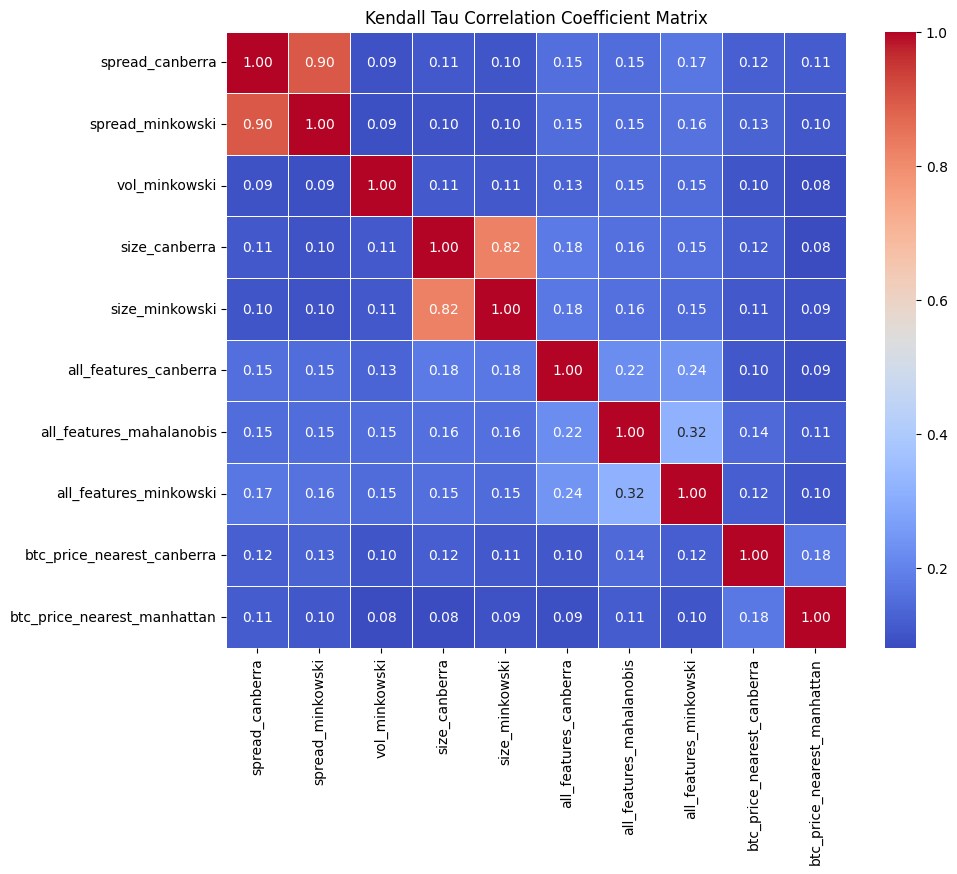

In [213]:
kendall_corr_matrix = pd.DataFrame(index=nearest_neighbors_per_feature.keys(), columns=nearest_neighbors_per_feature.keys())

for df_name1, df1 in nearest_neighbors_per_feature.items():
    for df_name2, df2 in nearest_neighbors_per_feature.items():
        corr_values = []
        for column in df1.columns:
            tau, _ = kendalltau(df1[column], df2[column])
            corr_values.append(tau)
        kendall_corr_matrix.loc[df_name1, df_name2] = np.mean(corr_values)
        
kendall_corr_matrix = kendall_corr_matrix.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(kendall_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Kendall Tau Correlation Coefficient Matrix")
plt.show()


# Extract features

In [214]:
feature_df = pd.DataFrame()

# 추출한 index가 비슷한 metric df 제거
del nearest_neighbors_per_feature['spread_minkowski']
del nearest_neighbors_per_feature['size_minkowski']

columns = btc_derived_feature.columns.to_list()
del columns[-1] # 종속변수 삭제 : feature가 되면 안된다


for df_name1, df1 in nearest_neighbors_per_feature.items():
    for col in btc_derived_feature.columns:
        feature_df[col+'_'+df_name1] = df1.apply(lambda row: btc_derived_feature.loc[row, col].mean(), axis=1)
        
feature_df = pd.merge(feature_df, btc_derived_feature, left_index=True, right_index=True, how='left')


In [215]:
feature_df

,wap1_spread_canberra,wap2_spread_canberra,log_return1_spread_canberra,log_return2_spread_canberra,log_return_ask1_spread_canberra,log_return_ask2_spread_canberra,log_return_bid1_spread_canberra,log_return_bid2_spread_canberra,wap_balance_spread_canberra,price_spread_spread_canberra,...,order_count,bucket_count_300_s,volatility_300_s,size_300_s,order_count_300_s,bucket_count_150_s,volatility_150_s,size_150_s,order_count_150_s,after_10m_volatility
0,2.227478e+07,2.227459e+07,0.000149,0.000146,0.000251,0.000256,0.000103,0.000108,1371.825160,12416.139796,...,0.089576,183.0,0.000180,23.459547,0.128194,102.0,0.000095,20.493226,0.200914,0.000175
1,2.228248e+07,2.228322e+07,-0.000275,-0.000251,-0.000292,-0.000257,-0.000210,-0.000207,1759.359792,8710.673092,...,0.043121,147.0,0.000200,5.310966,0.036129,65.0,0.000024,2.325664,0.035779,0.000089
2,2.218824e+07,2.218821e+07,-0.000249,-0.000262,-0.000341,-0.000343,-0.000199,-0.000186,1450.204940,6685.500574,...,0.045647,131.0,0.000066,7.669628,0.058547,56.0,0.000082,3.123785,0.055782,0.000131
3,2.225981e+07,2.226020e+07,-0.000507,-0.000516,-0.000570,-0.000579,-0.000495,-0.000501,1531.060196,9586.259541,...,0.048061,229.0,0.000109,8.792877,0.038397,129.0,0.000128,5.303256,0.041111,0.000192
4,2.234572e+07,2.234552e+07,0.000945,0.000921,0.000924,0.000918,0.000851,0.000834,1499.942867,13253.274052,...,0.054851,269.0,0.000167,13.701197,0.050934,110.0,0.000187,5.242204,0.047656,0.000173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,2.226506e+07,2.226556e+07,0.000274,0.000320,0.000252,0.000232,0.000248,0.000245,1333.183021,12794.805812,...,0.034249,308.0,0.000131,10.782033,0.035007,104.0,0.000162,3.088047,0.029693,0.000170
160,2.220254e+07,2.220287e+07,-0.000128,-0.000141,-0.000071,-0.000057,-0.000209,-0.000221,968.608486,12007.528996,...,0.039193,209.0,0.000155,7.416296,0.035485,130.0,0.000153,4.589887,0.035307,0.000147
161,2.224588e+07,2.224591e+07,-0.000142,-0.000174,-0.000183,-0.000187,-0.000130,-0.000151,1747.826435,9807.942256,...,0.030142,201.0,0.000111,6.903514,0.034346,124.0,0.000110,4.612272,0.037196,0.000209
162,2.224061e+07,2.224043e+07,0.000196,0.000191,0.000281,0.000282,0.000132,0.000135,1359.628336,12500.797590,...,0.042304,140.0,0.000232,6.171769,0.044084,92.0,0.000152,3.962917,0.043075,0.000150
